In [ ]:
import re
import os
import subprocess
import sys
from matplotlib import pyplot as plt
import pandas as pd


sys.path.append('../../')  # Add the path to the my_packages module
os.environ['EXPERIMENT_DB_NAME'] = "context_experiments"
from my_packages.analysis.error_analysis import categorize_semantic_errors, categorize_syntax_error, categorize_syntax_parsing_error, categorize_test_errors, extract_semantic_errors, extract_test_error, get_error_category_counts, make_categories_bar_chart, make_categories_pie_chart
from my_packages.db_service.error_service import delete_error_docs, errors_to_df, pretty_print_errors
from my_packages.evaluation.midio_compiler import compile_code, is_code_syntax_valid
from my_packages.db_service.experiment_service import experiment_exists, pretty_print_experiment_collections, run_experiment_quality_checks, setup_experiment_collection

experiment_name = f"regular_RAG_5_shot"
error_type = "semantic"
filter = {
    "eval_method": "3_fold",
    "model_name": "llama3.3:70b-instruct-fp16",
    "phase": "testing",
}
# Categorize and extract errors:
df = errors_to_df(experiment_name, filter=filter)
print(df.count())
df["syntax_error"] = df["stderr"]
df["syntax_parsing_error"] = df["stderr"].apply(categorize_syntax_parsing_error)
df["syntax_category"] = df["stderr"].apply(categorize_syntax_error)

df["semantic_error"] = df["error_msg"].apply(extract_semantic_errors)
df["semantic_category"] = df["error_msg"].apply(categorize_semantic_errors)

df["tests_category"] = df["test_result"].apply(categorize_test_errors)
df["tests_error"] = df.apply(
    lambda row: extract_test_error(row["tests_category"], row["error_msg"], row["test_result"]),
    axis=1
)

filtered_df = df[
    (df["error_type"] == error_type) 
    # & (df[f"{error_type}_category"] == {'Symbol Resolution Error'})
    # & (df[f"syntax_parsing_error"] == '[Parsing failed]') 

]
print(filtered_df.columns)


# Show all rows
pd.set_option('display.max_rows', None)     

# Show all columns
pd.set_option('display.max_columns', None)

# Show full content in each cell
pd.set_option('display.max_colwidth', None)

print(df["error_type"].unique())


errors_count_df = get_error_category_counts(filtered_df, f"{error_type}_category")
print(errors_count_df)

make_categories_pie_chart(errors_count_df, title=f"{error_type.capitalize()} Error Categories")
make_categories_bar_chart(errors_count_df, title=f"{error_type.capitalize()} Error Categories")


filtered_df.head(50)



# Compariison DF and tables

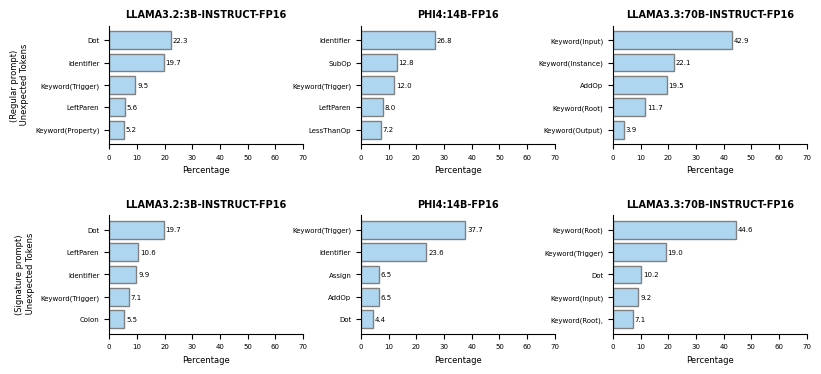

In [6]:
import re
import os
import subprocess
import sys
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

experiment = "context_experiments"
experiment_type = "RAG"
models = ["llama3.2:3b-instruct-fp16", "phi4:14b-fp16", "llama3.3:70b-instruct-fp16"]
prompts = ["regular", "signature"]
shot = 5

os.environ['EXPERIMENT_DB_NAME'] = experiment

sys.path.append('../../')  # Add the path to the my_packages module
from my_packages.analysis.error_analysis import (
    categorize_semantic_errors, 
    categorize_syntax_error, 
    categorize_syntax_parsing_error,
    categorize_test_errors, 
    extract_semantic_errors, 
    extract_test_error, 
    get_error_category_counts, 
    make_categories_bar_chart, 
    make_categories_pie_chart
)
from my_packages.db_service.error_service import delete_error_docs, errors_to_df, pretty_print_errors
from my_packages.evaluation.midio_compiler import compile_code, is_code_syntax_valid
from my_packages.db_service.experiment_service import experiment_exists, pretty_print_experiment_collections, run_experiment_quality_checks, setup_experiment_collection

def categorize_erors(experiment_name: str,
                     metric: str,
                     filter: dict
                    ):
    # Categorize and extract errors
    df = errors_to_df(experiment_name, filter=filter)
    if metric == "syntax":
        df["syntax_error"] = df["stderr"]
        df["syntax_parsing_error"] = df["stderr"].apply(categorize_syntax_parsing_error)
        df["syntax_category"] = df["stderr"].apply(categorize_syntax_error)
    elif metric == "semantic":
        df["semantic_error"] = df["error_msg"].apply(extract_semantic_errors)
        df["semantic_category"] = df["error_msg"].apply(categorize_semantic_errors)
    elif metric == "tests":
        df["tests_category"] = df["test_result"].apply(categorize_test_errors)
        df["tests_error"] = df.apply(
            lambda row: extract_test_error(row["tests_category"], row["error_msg"], row["test_result"]),
            axis=1
        )
    return df

def get_all_errors_comparison(metric, models, prompts, shot, parsing_errors = True):
    rows = []
    for model in models:
        for prompt in prompts:
            df = categorize_erors(
                experiment_name=f"{prompt}_{experiment_type}_{shot}_shot",
                metric=metric,
                filter={"eval_method": "3_fold", "model_name": model, "phase": "testing"},
            )
            filtered_df = df[df["error_type"] == metric]
            if parsing_errors:
                filtered_df = filtered_df[filtered_df["syntax_category"] == "Parsing failed"]
                errors_count_df = get_error_category_counts(filtered_df, f"{metric}_parsing_error")
            else:
                errors_count_df = get_error_category_counts(filtered_df, f"{metric}_category")
        
            # Loop over each error category row and append as individual rows
            # make_categories_pie_chart(errors_count_df, title=f"{error_type.capitalize()} Error Categories")
            # make_categories_bar_chart(errors_count_df, title=f"{error_type.capitalize()} Error Categories")
            for _, row in errors_count_df.iterrows():
                rows.append({
                    "model": model,
                    "prompt": prompt,
                    "shots": shot,
                    "category": row["category"],
                    "count": row["count"],
                    "percentage": row["percentage"],
                })
    return pd.DataFrame(rows)

if experiment_type == "full-context" and "phi4:14b-fp16" in models:
    models.remove("phi4:14b-fp16")

comparison_df = get_all_errors_comparison("syntax", models, prompts, shot, parsing_errors=True)

rows = len(prompts)
cols = len(models)
fig, axs = plt.subplots(rows, cols, figsize=((cols*3), (rows*2)))  # Slightly shorter height

for row_idx, prompt in enumerate(prompts):
    for col_idx, model in enumerate(models):
        ax = axs[row_idx, col_idx]
        df = comparison_df[
            (comparison_df["prompt"] == prompt) & (comparison_df["model"] == model)
        ]

        df = df.sort_values(by="percentage", ascending=False).head(5)
        df = df.sort_values(by="percentage", ascending=True)

        bars = ax.barh(df["category"], df["percentage"], color="#aed6f1", edgecolor="gray")

        for bar in bars:
            width = bar.get_width()
            ax.text(width + 0.6, bar.get_y() + bar.get_height() / 2,
                    f"{width:.1f}", va="center", fontsize=5)

        # Enhance title
        model_label = model.upper()
        ax.set_title(model_label, fontsize=7, fontweight='bold')
        ax.set_xlim(0, 70)
        ax.set_xlabel("Percentage", fontsize=6)
        ax.set_ylabel(f"({prompt.capitalize()} prompt)\n Unexpected Tokens", fontsize=6) if col_idx == 0 else ax.set_ylabel("")
        ax.tick_params(axis='both', labelsize=5)
        ax.spines[['top', 'right']].set_visible(False)

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.3, hspace=0.60)
# plt.tight_layout(pad=0.1)
plt.savefig(f"{experiment_type}_{experiment}_top5_unexpected_tokens_all_models_compact.png", dpi=300)
plt.show()
